In [59]:
# pip install geopandas

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import trim_mean
from statsmodels import robust
import seaborn as sns

# Conditions Contibuting to Covid-19 for each state of USA

In [61]:
# Import data
data = pd.read_csv('covid19.csv')
# set display option because we have a lot of features to visualize
pd.set_option('display.max_columns',20)
# Visulize data
data.head()

,Data As Of,Start Date,End Date,Group,Year,Month,State,Condition Group,Condition,ICD10_codes,Age Group,COVID-19 Deaths,Number of Mentions,Flag
0,09/24/2023,01/01/2020,09/23/2023,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,0-24,1569.0,1647.0,NaN
1,09/24/2023,01/01/2020,09/23/2023,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,25-34,5804.0,6029.0,NaN
2,09/24/2023,01/01/2020,09/23/2023,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,35-44,15080.0,15699.0,NaN
3,09/24/2023,01/01/2020,09/23/2023,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,45-54,37414.0,38878.0,NaN
4,09/24/2023,01/01/2020,09/23/2023,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,55-64,82668.0,85708.0,NaN


# Duplicates and Null Values

In [62]:
# let's check for Null Values if existed
checkNull = data.isna().any()
if checkNull.any()==1:
    NullFeatures = checkNull[checkNull==1]
    # the treatment is fillna with 0 because the features doesnt have a 0 value to make a coincidence between the nan converted and the real value
    data.fillna(0,inplace=True)
    # Verification
    print(f'Data contains any null values:{data.isna().any().any()}')
else:
    print('No Null values')

Data contains any null values:False


In [63]:
# let's check for duplicated Records
if data.duplicated().sum()==0:
    print('No duplicated Records')

No duplicated Records


# Data Types Format Analysis 

In [64]:
# let's change data types of our dataset for type consitency 
# First check current data types
data.info()
# Our transformation
data['Data As Of'] = pd.to_datetime(data['Data As Of'])
data['Start Date'] = pd.to_datetime(data['Start Date'])
data['End Date'] = pd.to_datetime(data['End Date'])
data['Year'] = data['Year'].astype(int)
data['Month'] = data['Month'].astype(int)
data['Condition'] = data['Condition'].astype('category')
data['Age Group'] = data['Age Group'].astype('category')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621000 entries, 0 to 620999
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Data As Of          621000 non-null  object 
 1   Start Date          621000 non-null  object 
 2   End Date            621000 non-null  object 
 3   Group               621000 non-null  object 
 4   Year                621000 non-null  float64
 5   Month               621000 non-null  float64
 6   State               621000 non-null  object 
 7   Condition Group     621000 non-null  object 
 8   Condition           621000 non-null  object 
 9   ICD10_codes         621000 non-null  object 
 10  Age Group           621000 non-null  object 
 11  COVID-19 Deaths     621000 non-null  float64
 12  Number of Mentions  621000 non-null  float64
 13  Flag                621000 non-null  object 
dtypes: float64(4), object(10)
memory usage: 66.3+ MB


# Verification

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621000 entries, 0 to 620999
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Data As Of          621000 non-null  datetime64[ns]
 1   Start Date          621000 non-null  datetime64[ns]
 2   End Date            621000 non-null  datetime64[ns]
 3   Group               621000 non-null  object        
 4   Year                621000 non-null  int32         
 5   Month               621000 non-null  int32         
 6   State               621000 non-null  object        
 7   Condition Group     621000 non-null  object        
 8   Condition           621000 non-null  category      
 9   ICD10_codes         621000 non-null  object        
 10  Age Group           621000 non-null  category      
 11  COVID-19 Deaths     621000 non-null  float64       
 12  Number of Mentions  621000 non-null  float64       
 13  Flag                621000 no

# Statistical Moments : Location, Variability, Skewness, Kurtosis

In [66]:
# Group Features based on the type Numerical vs Categorical
cat_cols=data.select_dtypes(include=['object','category']).columns
num_cols = data.select_dtypes(include=np.number).columns.tolist()
Metrics = pd.DataFrame()
for column in num_cols:
    Metrics = Metrics._append({
        'Feature':column,
        'Mean':data[column].mean(),
        'Median':data[column].median(),
        'Range':data[column].max() - data[column].min(),
        'IQR':data[column].quantile(q=0.75) - data[column].quantile(q=0.25),
        'STD':data[column].std(),
        'Variance':data[column].var(),
        'Skewness [-1,1]':round(data[column].skew(),2),
        'Kurtosis[-2,2]':round(data[column].kurtosis(),2)
    },ignore_index=True)

# Iterate over each categorical column
for column in cat_cols:
    # Calculate the mode for the current column
    mode_value = data[column].mode().iloc[0]  # Get the first mode if there are multiple modes
    
    # Append the feature name and its mode to the mode_df DataFrame
    Metrics = Metrics._append({'Feature': column, 'Mode': mode_value}, ignore_index=True)

# Display the DataFrame with feature names and their corresponding modes 
Metrics.head(len(cat_cols)+len(num_cols))

,Feature,Mean,Median,Range,IQR,STD,Variance,"Skewness [-1,1]","Kurtosis[-2,2]",Mode
0,Year,1980.980000,2021.0,2023.0,2.0,282.999414,8.008867e+04,-6.86,45.02,NaN
1,Month,5.580000,5.5,12.0,7.0,3.682882,1.356362e+01,0.09,-1.15,NaN
2,COVID-19 Deaths,84.634003,0.0,1146242.0,0.0,2502.177502,6.260892e+06,227.68,82355.94,NaN
3,Number of Mentions,92.351058,0.0,1146242.0,0.0,2707.996859,7.333247e+06,212.99,69347.69,NaN
4,Group,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,By Month
5,State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alabama
6,Condition Group,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Circulatory diseases
7,Condition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult respiratory distress syndrome
8,ICD10_codes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"A00-A39, A42-B99, D00-E07, E15-E64, E70-E90, F..."
9,Age Group,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-24


Observation : Data is not well Ditributed bec it is affected by skewness, see below the form to confirm the observation, and skewness values above .

Year


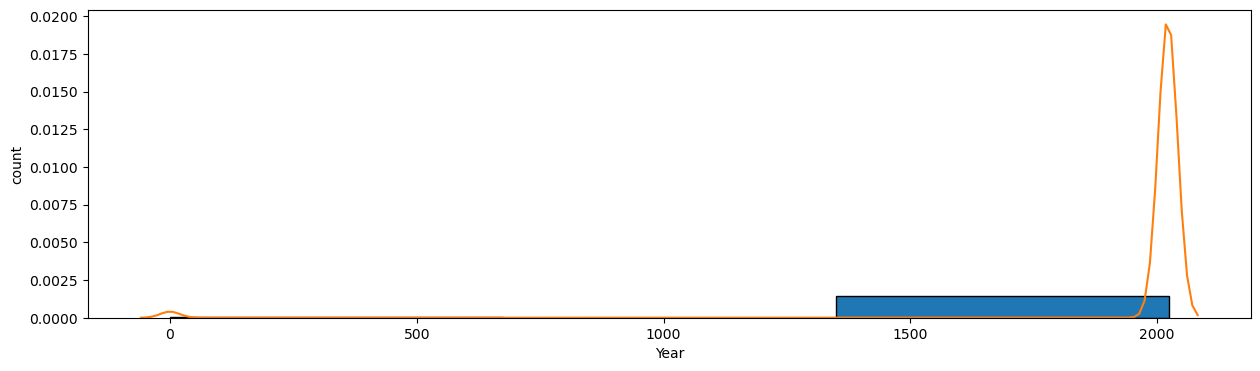

Month


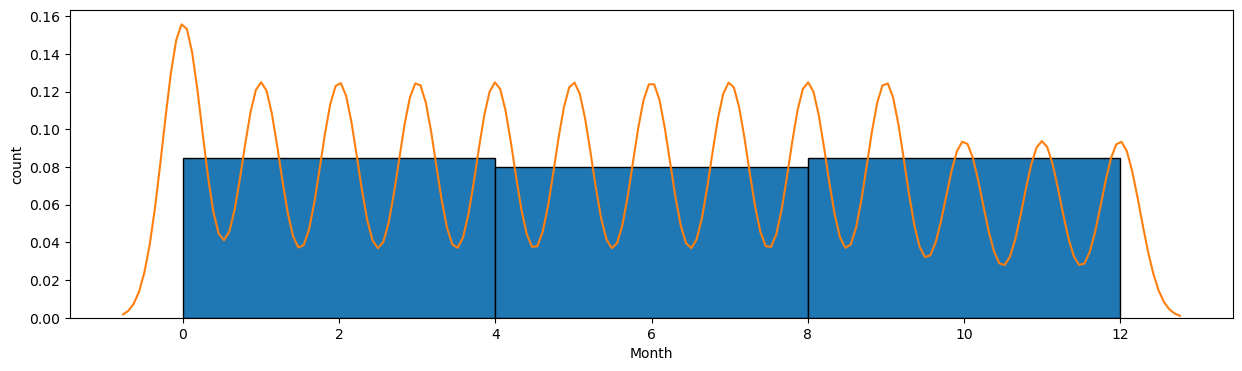

COVID-19 Deaths


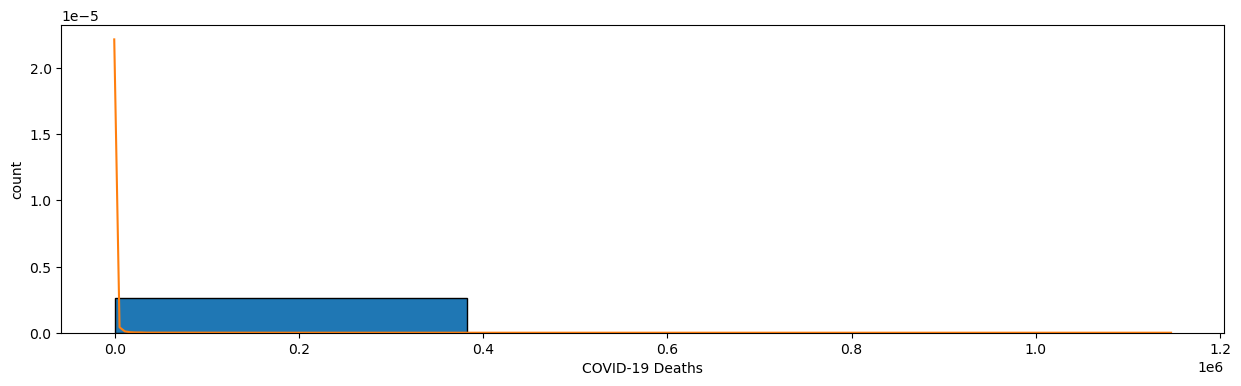

Number of Mentions


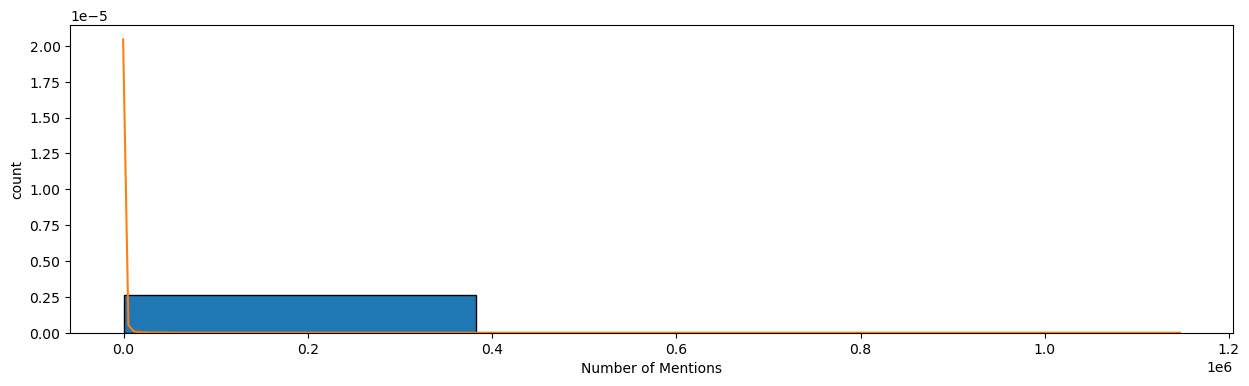

In [67]:
# let's visualize the Numerical Features
for col in num_cols:
    print(col)
    plt.figure(figsize = (15, 4))
    data[col].hist(grid=False,edgecolor='black',bins=3,density=True)
    sns.kdeplot(data[col])
    plt.ylabel('count')
    plt.show()

# Analyse Covid 19 Deaths using diffrent features

In [68]:
# now we will group data and see what insights we can get for 2019--2023
# 1. Condition Group impact on covid deaths
cdt_grp_death_mean = data.groupby('Condition Group')['COVID-19 Deaths'].mean().apply(lambda x: np.round(x,2)).sort_values(ascending=False)
# 2. Condition impact on covid deaths
Condition_mean_death  = data.groupby('Condition')['COVID-19 Deaths'].mean().apply(lambda x: np.round(x,2)).sort_values(ascending=False)
# 3. Age Grp with higher  covid deaths
age_grp_mean_death  = data[data['Age Group']!='All Ages'].groupby('Age Group')['COVID-19 Deaths'].mean().apply(lambda x: np.round(x,2)).sort_values(ascending=False)
# 4. State with higher covid deaths
state_mean_death = data[data['State']!='United States'].groupby('State')['COVID-19 Deaths'].mean().apply(lambda x: np.round(x,2)).sort_values(ascending=False)
# 5. How often a condition is named in the data set
cdt_mention = data.groupby('Condition')['Number of Mentions'].sum()
# 4. State vs condition is named in the data set
state_mention = data[data['State']!='United States'].groupby('State')['Number of Mentions'].mean().sort_values(ascending=False)

# let's visualize the metrics we found

Text(0.5, 1.0, 'Mean COVID-19 Deaths by Condition Group')

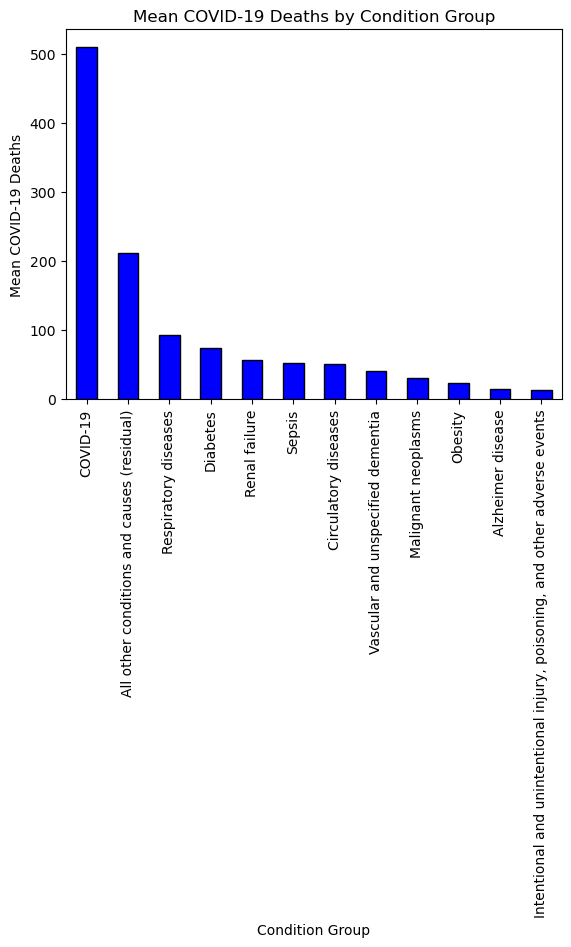

In [69]:
%matplotlib inline
cdt_grp_death_mean.reset_index().plot(x='Condition Group', y='COVID-19 Deaths',kind='bar',legend=False,color='blue',edgecolor='black')
plt.xlabel('Condition Group')
plt.ylabel('Mean COVID-19 Deaths')
plt.title('Mean COVID-19 Deaths by Condition Group')

As we can see, aside from residuals and COVID-19, respiratory diseases are the highest condition group with the most COVID-19 deaths

As we can see, aside from residuals and COVID-19, Influenza and pneumonia condition wich is included inrespiratory diseases  has the highest condition group with the most COVID-19 deaths.


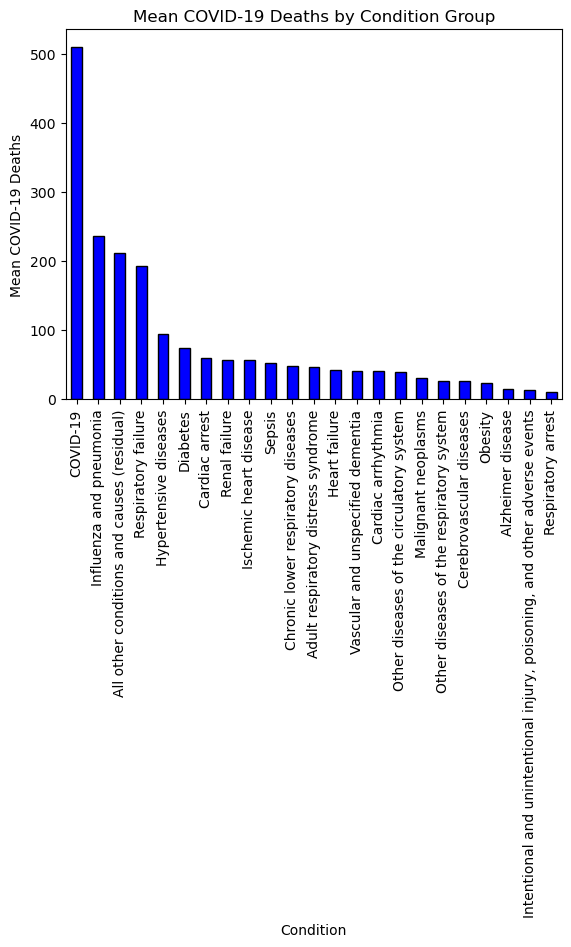

In [70]:
# let's visualize the metrics we found
%matplotlib inline
Condition_mean_death.reset_index().plot(x='Condition', y='COVID-19 Deaths',kind='bar',legend=False,color='blue',edgecolor='black')
plt.xlabel('Condition')
plt.ylabel('Mean COVID-19 Deaths')
plt.title('Mean COVID-19 Deaths by Condition Group')
print("As we can see, aside from residuals and COVID-19, Influenza and pneumonia condition wich is included inrespiratory diseases  has the highest condition group with the most COVID-19 deaths.")

As we can see, aside from residuals and COVID-19, Influenza and pneumonia condition wich is included in respiratory diseases  has the highest condition group with the most COVID-19 deaths, see below to see how we confirm this inclusion.

In [71]:
# CHECK FOR Condition Group
condition_check = 'Respiratory diseases'
condition_value = 'Influenza and pneumonia'
# Check if the condition value is included in the 'Condition Group' column
dataIndexed = data.set_index('Condition Group')['Condition']
getIndex = dataIndexed.index[dataIndexed == condition_value].unique().tolist()
if getIndex[0]==condition_check:
    print(f'The {condition_value} is included in the condition group {condition_check}')
else:
    print('Not Included')

The Influenza and pneumonia is included in the condition group Respiratory diseases


Text(0.5, 1.0, 'Mean COVID-19 Deaths by Age Group')

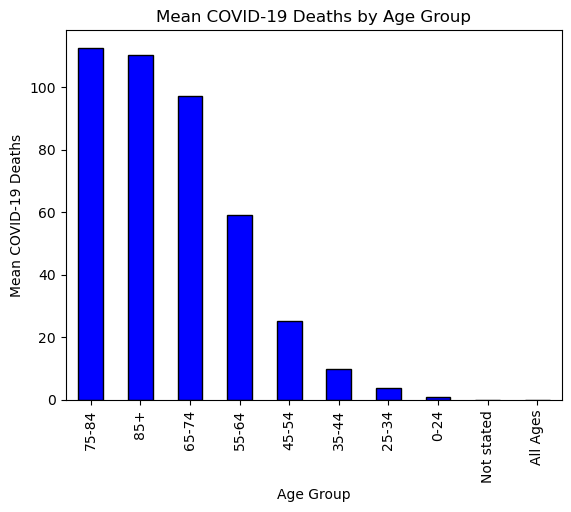

In [72]:
# let's visualize the metrics we found
%matplotlib inline
age_grp_mean_death.reset_index().plot(x='Age Group', y='COVID-19 Deaths',kind='bar',legend=False,color='blue',edgecolor='black')
plt.xlabel('Age Group')
plt.ylabel('Mean COVID-19 Deaths')
plt.title('Mean COVID-19 Deaths by Age Group')

As we can see, the most deaths by COVID-19 are among older people in the age range of 65-84+

Text(0.5, 1.0, 'Mean COVID-19 Deaths by State')

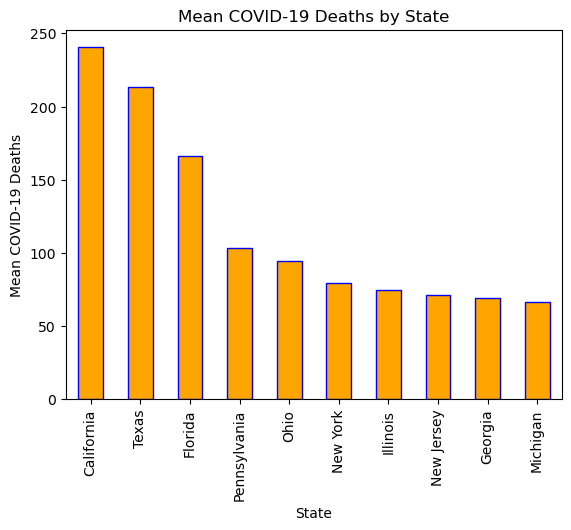

In [73]:
# let's visualize the metrics we found
%matplotlib inline
state_mean_death.reset_index().head(10).plot(x='State', y='COVID-19 Deaths',kind='bar',legend=False,color='orange',edgecolor='blue')
plt.xlabel('State')
plt.ylabel('Mean COVID-19 Deaths')
plt.title('Mean COVID-19 Deaths by State')

As we can see, the most deaths by COVID-19 are in California State, which is corrected based on https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/ see image below retrived in the date 27/05/2024.
.The deaths numbers arent equal(our values and the website stats) due to diffrent date ranges

Text(0.5, 1.0, 'Results Image')

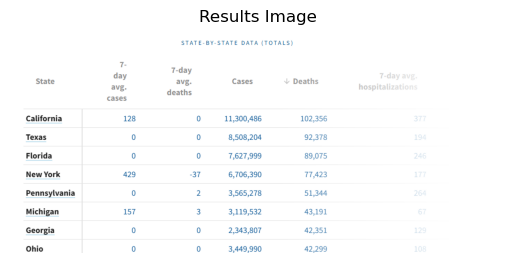

In [74]:
# Results by state
img = plt.imread('results.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title('Results Image')

Text(0.5, 1.0, 'Mean Cdt Number of Mention by State')

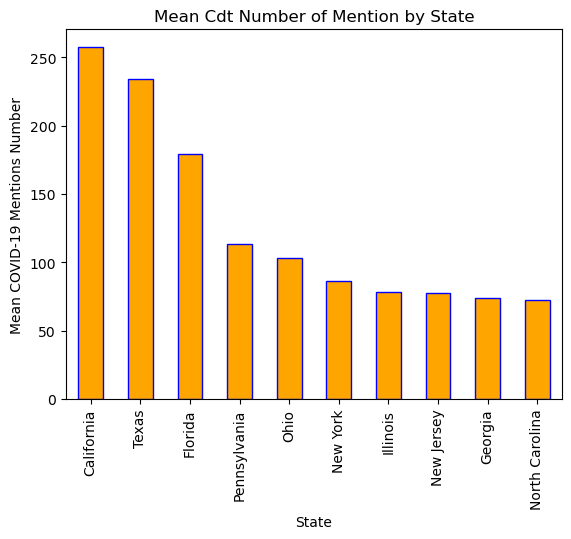

In [75]:
# Also we can see that by seeing the Avg of Condition Number of Mentions that justify that California has most deaths by Covid19
# let's visualize the metrics we found
%matplotlib inline
state_mention.reset_index().head(10).plot(x='State', y='Number of Mentions',kind='bar',legend=False,color='orange',edgecolor='blue')
plt.xlabel('State')
plt.ylabel('Mean COVID-19 Mentions Number')
plt.title('Mean Cdt Number of Mention by State')

As we can see, the most deaths by COVID-19 Mentions Number are in California State, which is corrected based on Death average

# Multivariate Aanlysis

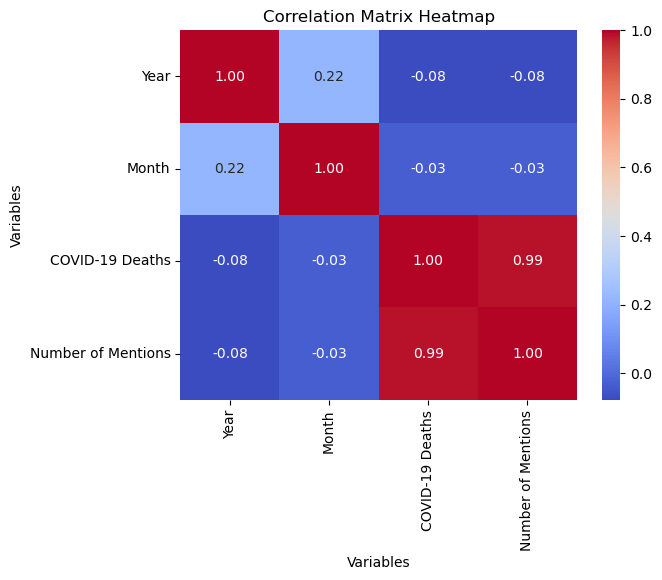

In [76]:
# Calculate the correlation matrix
matrix_corr = data[num_cols].corr()

# Create a heatmap
sns.heatmap(matrix_corr, annot=True, fmt='.2f', cmap='coolwarm')

# Adding labels and title for clarity
plt.title('Correlation Matrix Heatmap')
plt.xlabel('Variables')
plt.ylabel('Variables')

# Display the heatmap
plt.show()

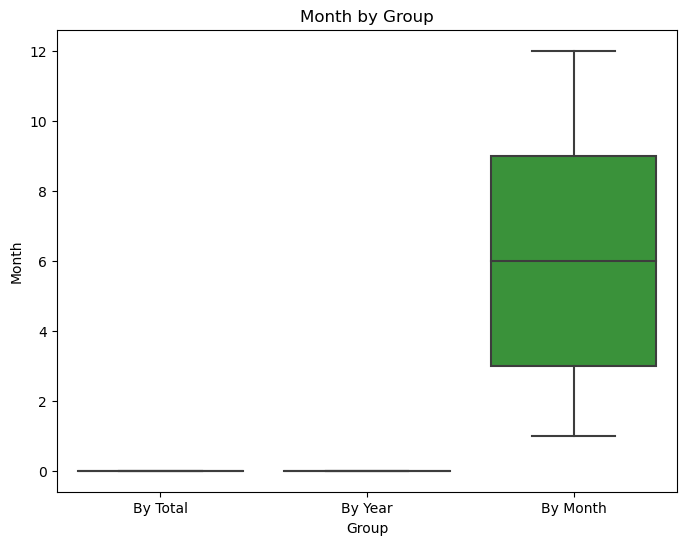

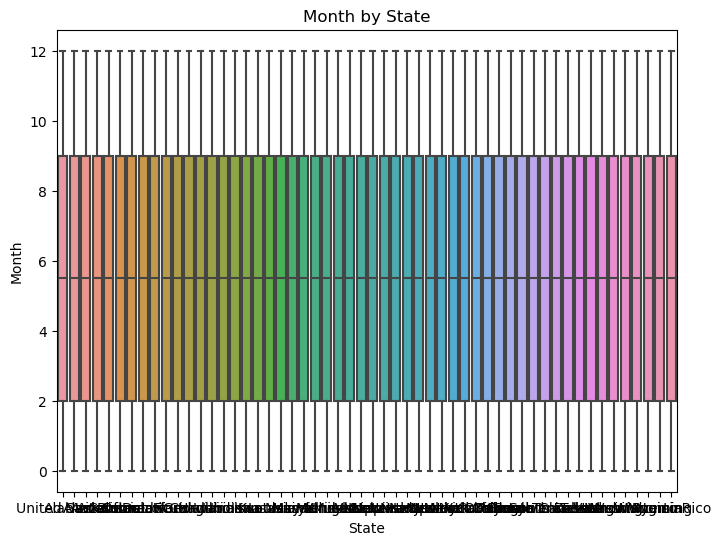

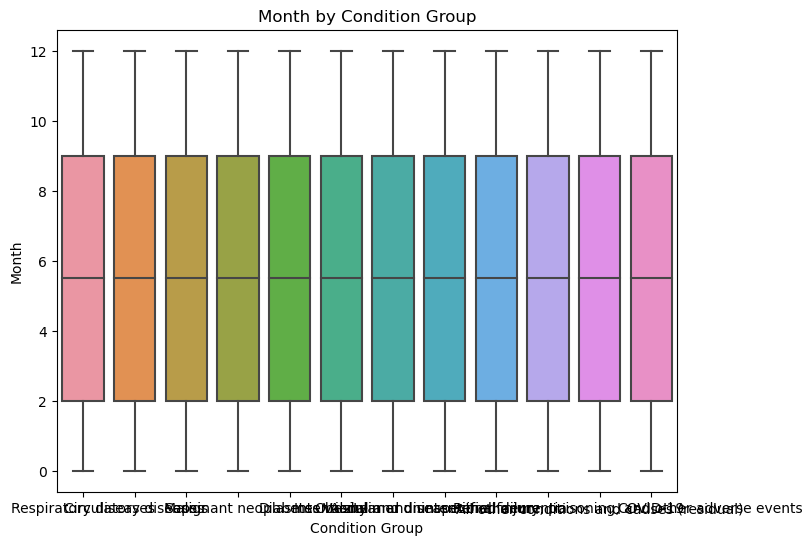

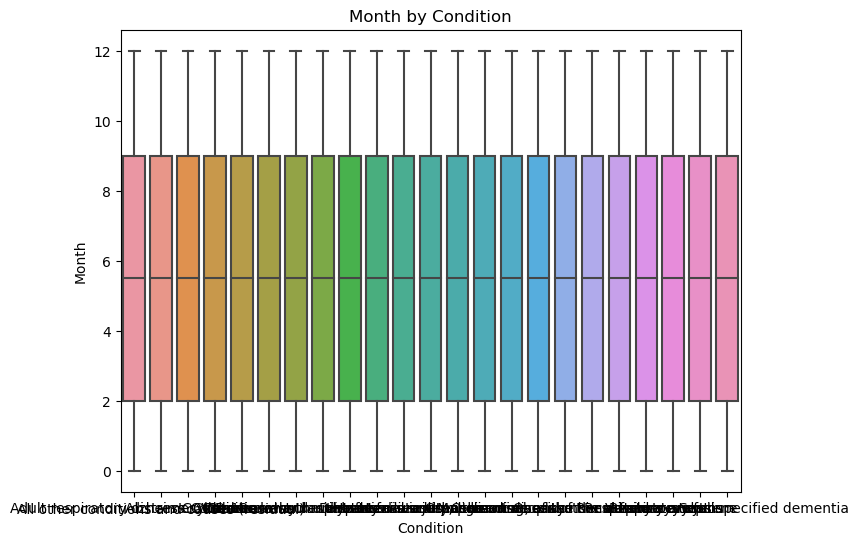

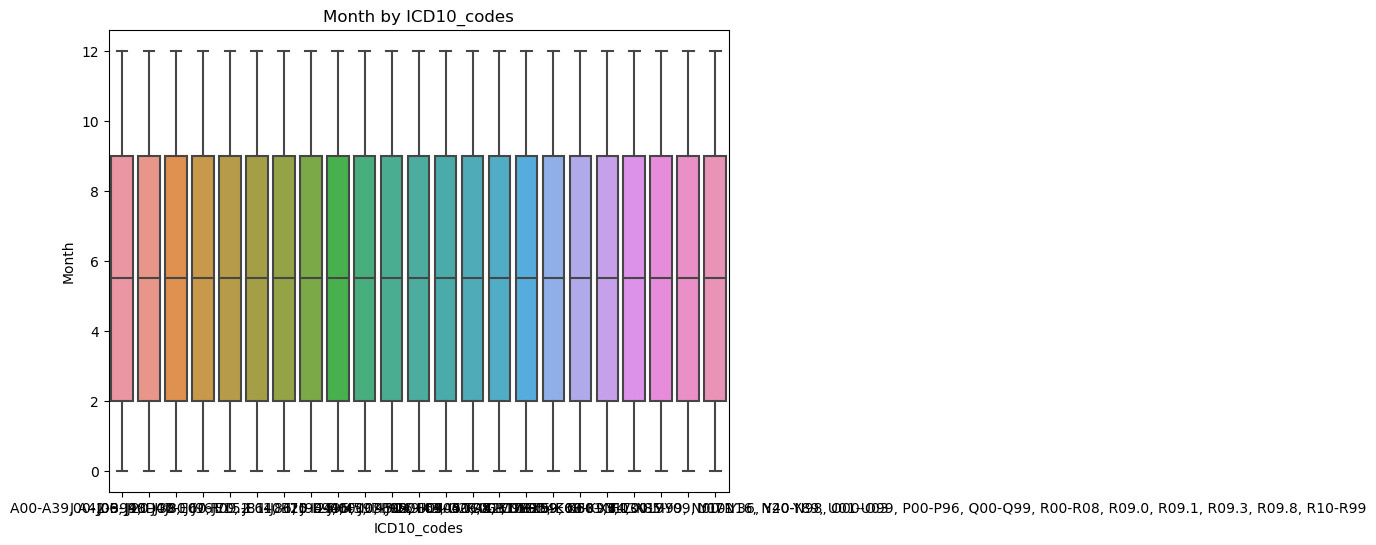

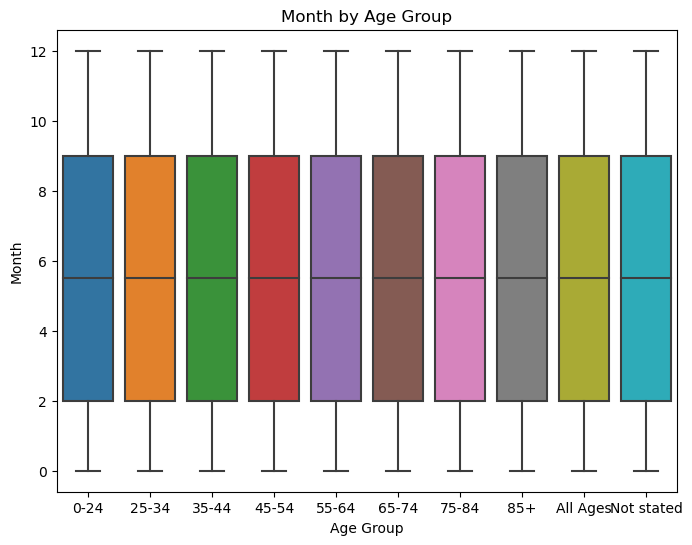

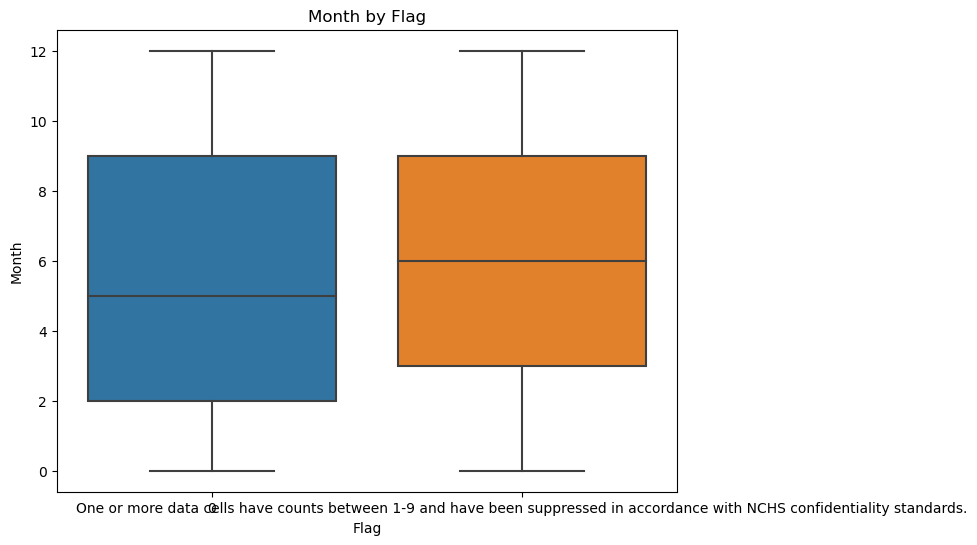

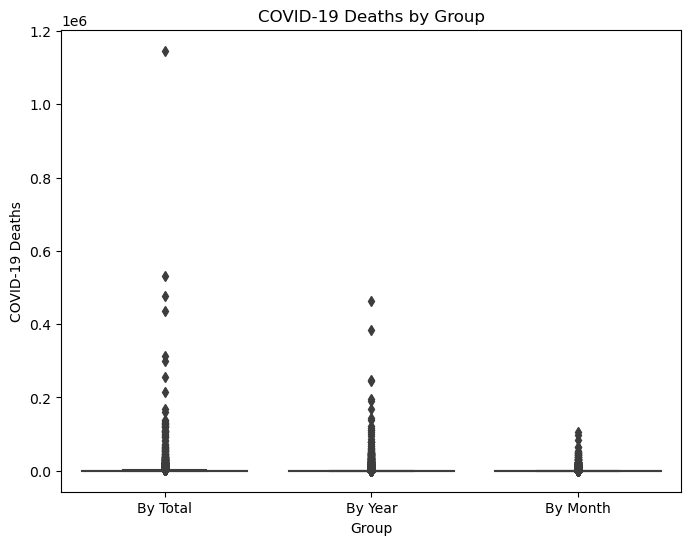

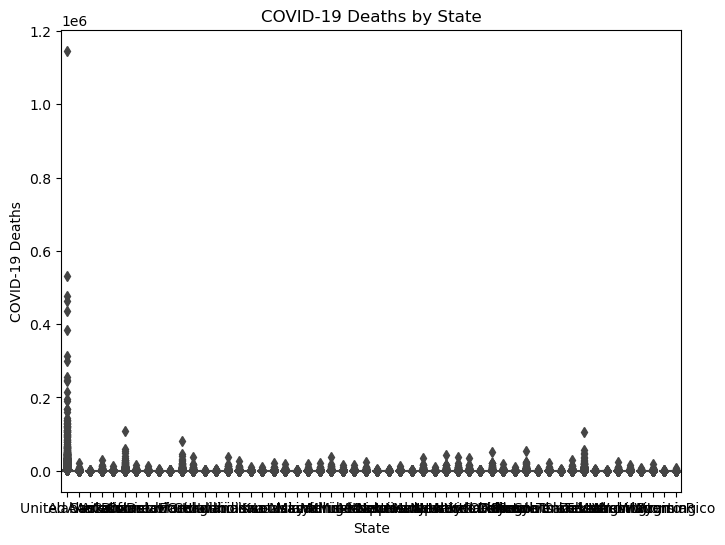

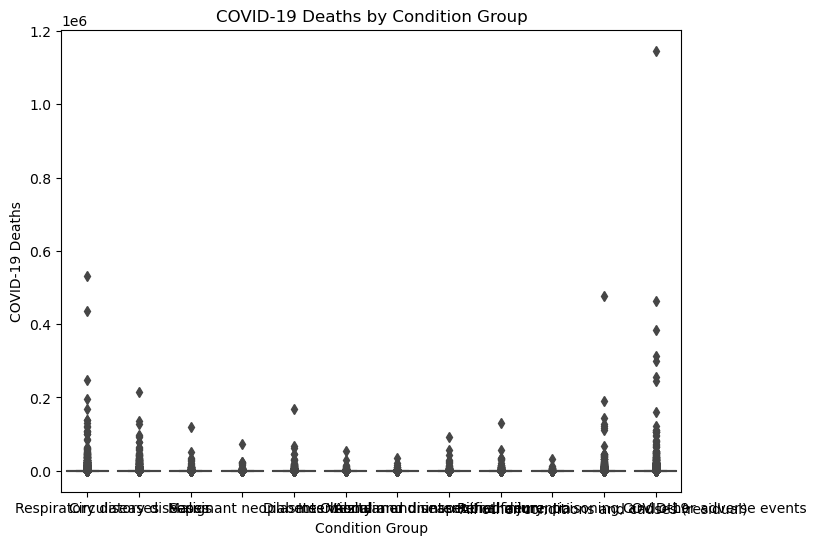

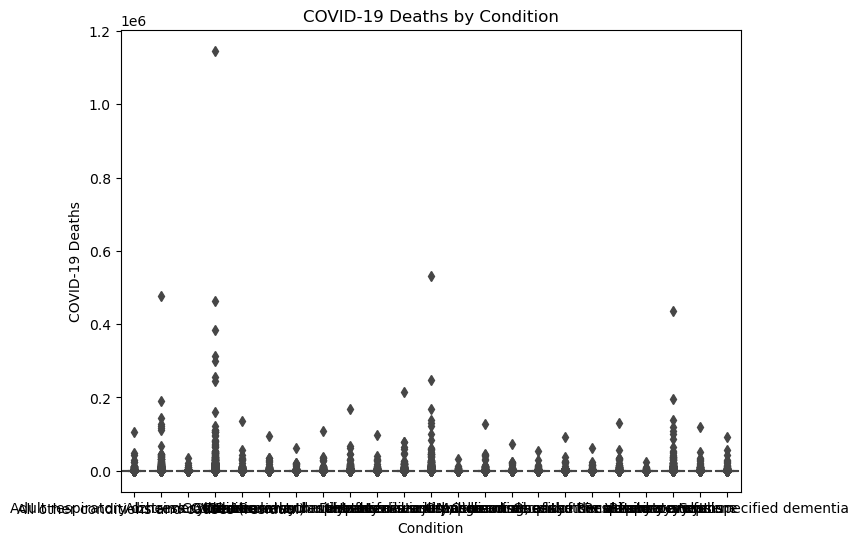

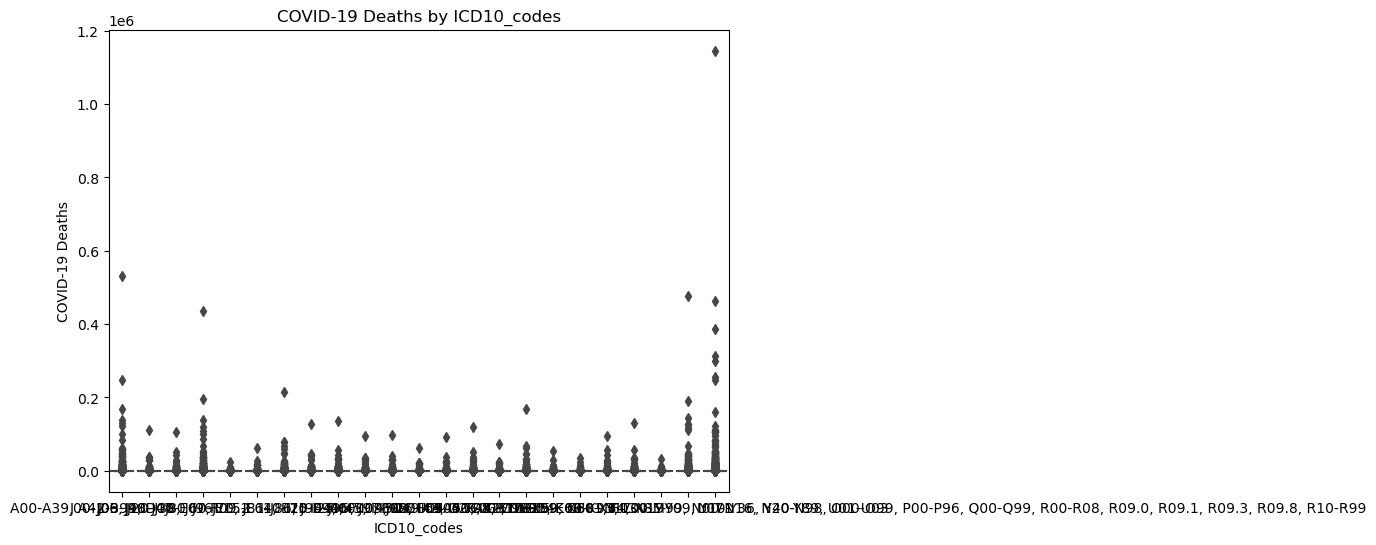

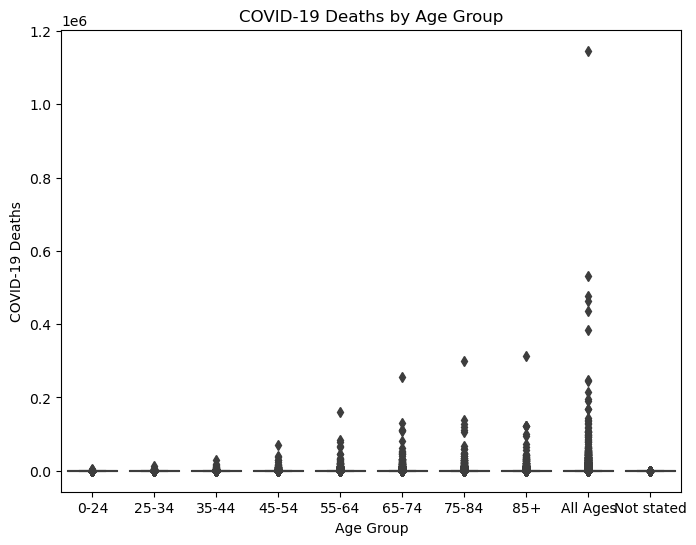

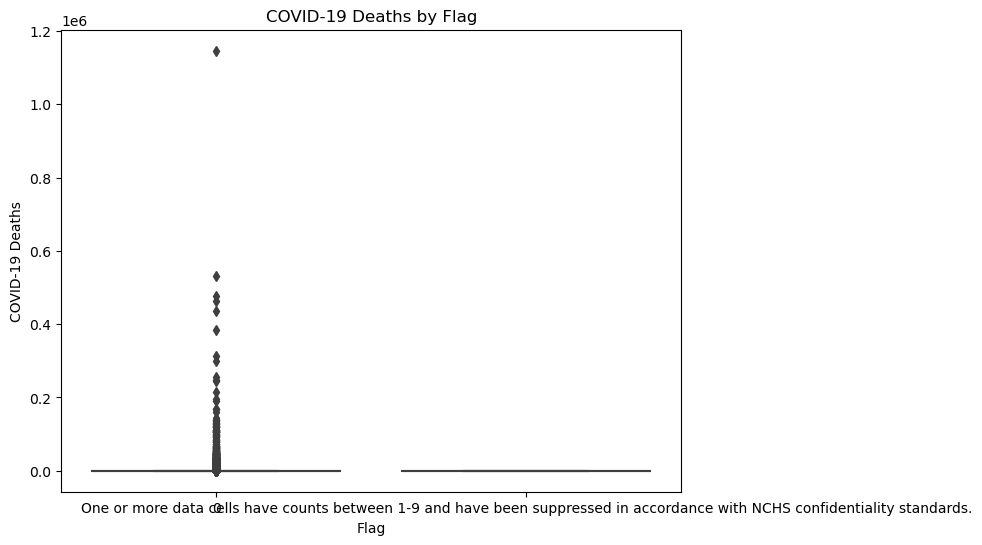

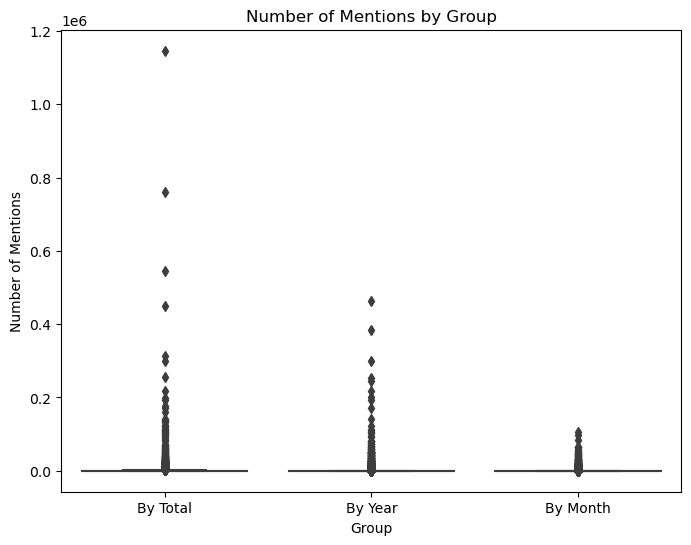

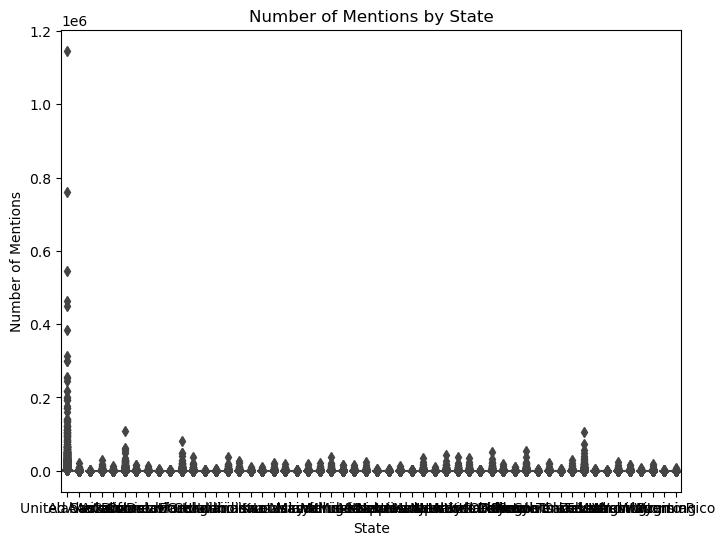

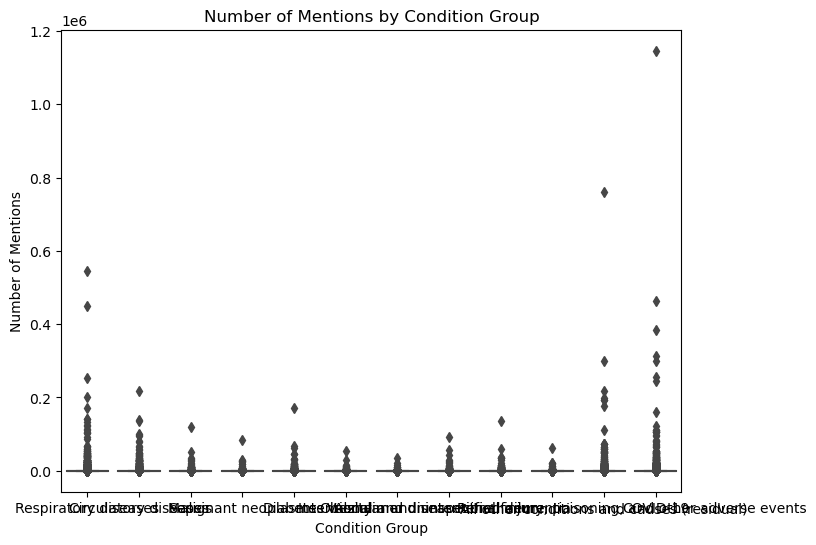

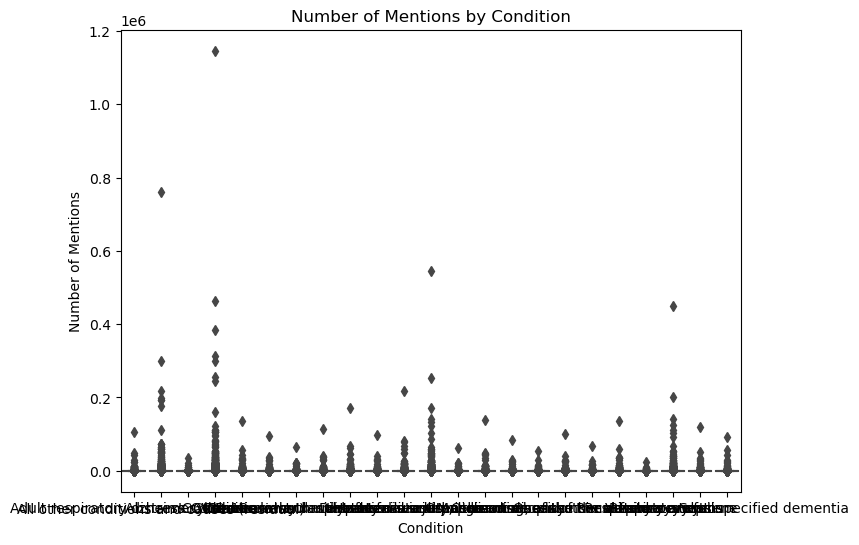

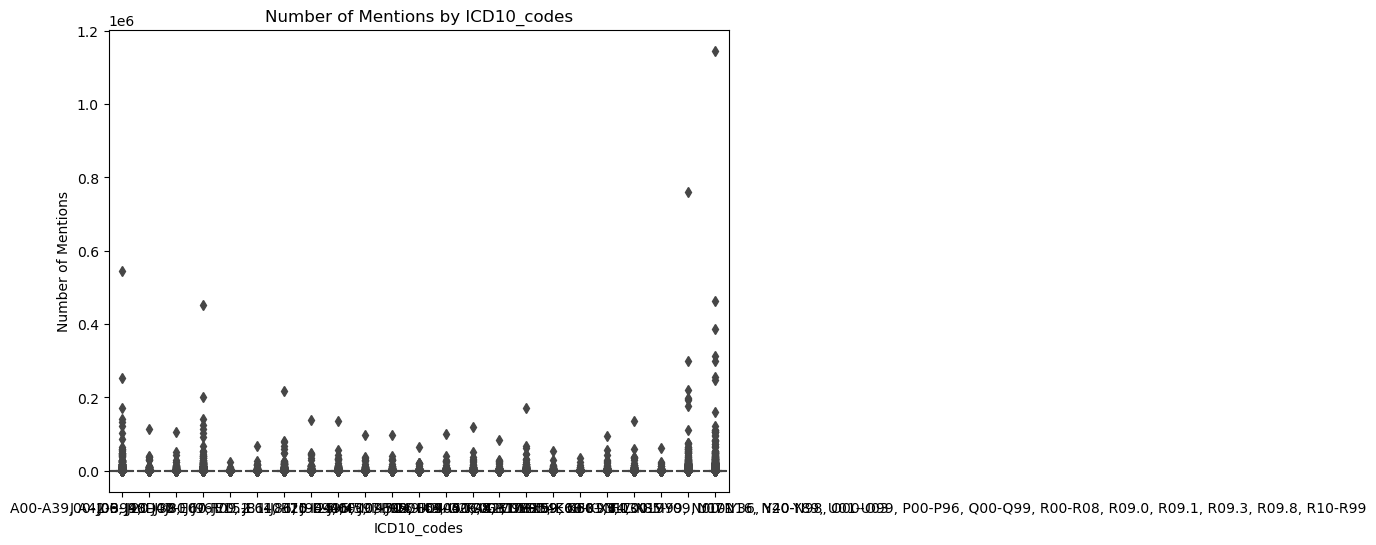

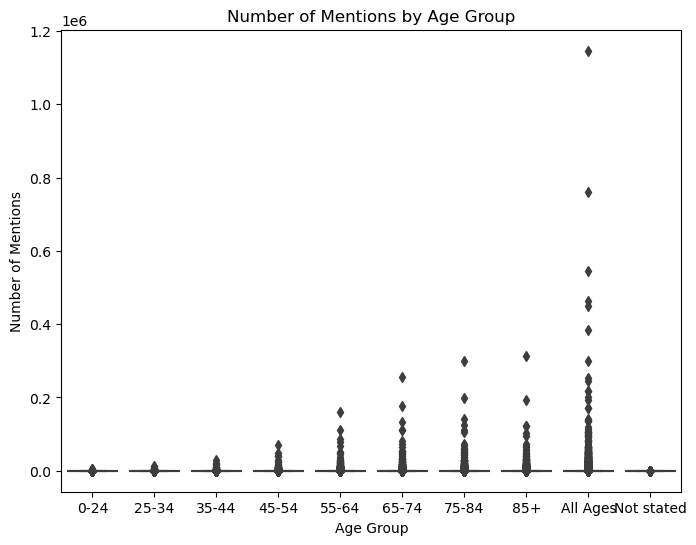

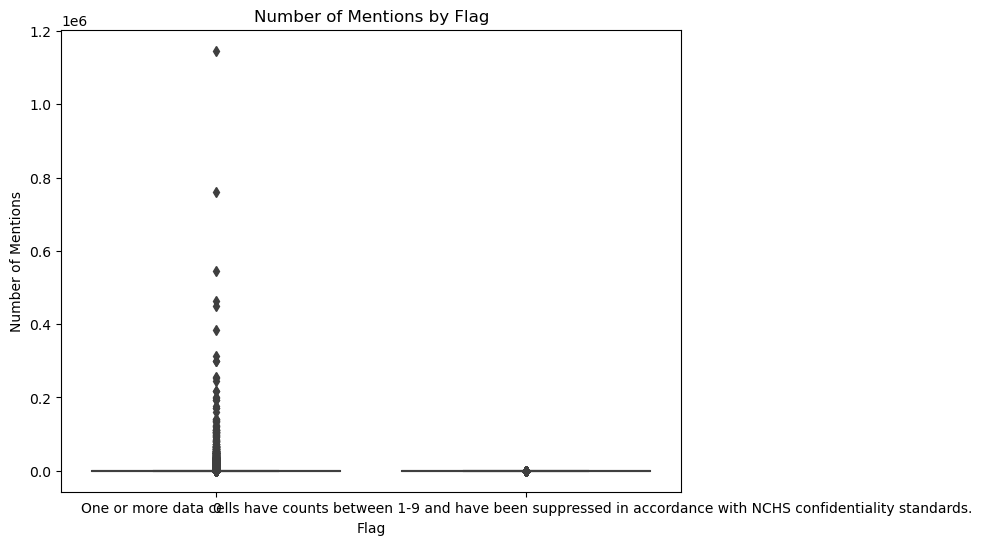

In [77]:
# Iterate through each combination of numerical and categorical columns
for num_col in num_cols:
    if num_col !='Year':
        for cat_col in cat_cols:
            if cat_col !='Name' and cat_col!='Model':
                # Create a new figure for each plot
                plt.figure(figsize=(8, 6))

                # Plot boxplot
                sns.boxplot(x=cat_col, y=num_col, data=data)

                # Set title and labels
                plt.title(f'{num_col} by {cat_col}')
                plt.xlabel(cat_col)
                plt.ylabel(num_col)
                # Show plot
                plt.show()